# Almost Visual Inertial Odometry

# Imports

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import MobileNetV2
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm import tqdm
from  matplotlib import pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

# Constants

In [2]:
SEED = 20197
BATCH_SIZE = 16
TEST_BATCH_SIZE = 32
GAMMA = 0.1   # torch default
LR=0.001 
EPOCHS = 50

In [71]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device

In [3]:
available_cuda = torch.cuda.is_available()
print(f"Available cuda: {available_cuda}")

device = torch.device("cuda" if available_cuda else "cpu")

Available cuda: False


In [91]:
a = np.array([4, 9.81, 9.81])
b = np.stack([a, a, a])
c = np.array([1, 9.81, 9.81])

b, b/c

(array([[4.  , 9.81, 9.81],
        [4.  , 9.81, 9.81],
        [4.  , 9.81, 9.81]]),
 array([[4., 1., 1.],
        [4., 1., 1.],
        [4., 1., 1.]]))

# Dataset

In [76]:
class AdvioDataset(torch.utils.data.Dataset):
      def __init__(self, df_frames, path_frames_folder, path_inertials, path_labels):
            self.path_frames_folder = path_frames_folder
            self.path_labels = path_labels
            self.path_inertials = path_inertials
            self.df_frames = df_frames

      def __len__(self):
            return len(self.df_frames) - 1

      def __getitem__(self, index):

            # load sample of frames
            image_name = self.path_frames_folder + self.df_frames.iloc[index, 1]
            frame = imread(image_name)
            frame = torch.Tensor(frame)
            frame = torch.moveaxis(frame, -1, 0)

            image_name_next = self.path_frames_folder + self.df_frames.iloc[index+1, 1]
            frame_next = imread(image_name_next)
            frame_next = torch.Tensor(frame_next)
            frame_next = torch.moveaxis(frame_next, -1, 0)

            sample_frame = frame_next - frame

            # TODO build buffer sample of inertials
            sample_inertials = ""

            # load labels
            label_odometry = np.load(self.path_labels + f"{self.df_frames.iloc[index, 0]}.npy")
            label_odometry = torch.Tensor(label_odometry)

            # load inertials
            label_inertial = np.load(self.path_inertials + f"{self.df_frames.iloc[index, 0]}.npy")
            # FIXME fast patch to not normalized inertials on y and z
            label_inertial /= np.array([1, 9.81, 9.81])  
            label_inertial = torch.Tensor(label_inertial)

            return sample_frame, label_odometry, label_inertial


path_frames = "./data/advio-01/iphone/frames_synced.csv"
path_frames_folder = "./data/advio-01/iphone/frames/"
path_inertials = "./data/advio-01/iphone/inertials/"
path_labels = "./data/advio-01/iphone/labels/"

df_frames = pd.read_csv(path_frames)
df_frames = df_frames.sample(frac = 1)    # shuffle rows
length = df_frames.shape[0]
train_split = 0.6
val_split = 0.2
test_split = 0.2
assert train_split + val_split + test_split == 1

df_train = df_frames[:round(train_split*length)]
df_val = df_frames[round(train_split*length):-round(val_split*length)]
df_test = df_frames[-round(val_split*length):]

train_data = AdvioDataset(df_train, path_frames_folder, path_inertials, path_labels)
val_data = AdvioDataset(df_val, path_frames_folder, path_inertials, path_labels)
test_data = AdvioDataset(df_test, path_frames_folder, path_inertials, path_labels)

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 1,
          'drop_last':True}
train_loader = torch.utils.data.DataLoader(train_data, **params)
val_loader = torch.utils.data.DataLoader(val_data, **params)
test_loader = torch.utils.data.DataLoader(test_data, **params)

In [63]:
for idx, (sample, label_odometry, _) in enumerate(train_loader):
    label_odometry = label_odometry.mean(axis=1)
    print(sample.shape)

    break

torch.Size([16, 3, 224, 224])


# Model

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv2d_odometry = MobileNetV2(num_classes=3)

    def forward(self, x):
        x = self.conv2d_odometry(x)
        return x

# Training

In [34]:
def normalize(data):
  data = data - data.min()
  data = data / data.max()
  return data

In [82]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    history_loss = 0

    for batch_idx, (data, labels_odometry, _) in enumerate(train_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        #forward
        optimizer.zero_grad()
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, label_odometry))

        # backward
        loss.backward()
        optimizer.step()

        #stats
        history_loss += loss.item()

        if batch_idx%60==0:
            print(f"\t[# {batch_idx}] loss: {loss.item()}")

    return history_loss/(len(train_loader)/BATCH_SIZE) # average epoch loss


In [85]:
def validation(model, device, val_loader, epoch):
    model.train()
    history_loss=0

    for batch_idx, (data, labels_odometry, _) in enumerate(val_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        # forward
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, labels_odometry))

        #stats
        history_loss += loss.item()
        if batch_idx%20==0:
            print(f"\t[# {batch_idx}] loss: {loss.item()}")

    return history_loss/(len(val_loader)/BATCH_SIZE) # average epoch loss


In [86]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

h_loss_train = []
h_loss_val = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    loss_train = train(model, device, train_loader, optimizer, epoch)
    loss_test = validation(model, device, val_loader, epoch)

    #populating the history of the loss
    h_loss_train.append(loss_train)
    h_loss_val.append(loss_test)

Epoch 1/50
	[# 0] loss: 0.02477937936782837
	[# 60] loss: 0.006899261847138405
	[# 120] loss: 0.005593923851847649
	[# 180] loss: 0.0035104900598526
	[# 240] loss: 0.003978492226451635
	[# 300] loss: 0.0015343938721343875
	[# 360] loss: 0.0010721064172685146
	[# 420] loss: 0.0008581450092606246
	[# 480] loss: 0.0005106939352117479
	[# 0] loss: 0.0008350355201400816
	[# 20] loss: 0.0009670749423094094
	[# 40] loss: 0.0007735203835181892
	[# 60] loss: 0.0006932790856808424
	[# 80] loss: 0.0008582965820096433
	[# 100] loss: 0.0008996230899356306
	[# 120] loss: 0.0008678908343426883
	[# 140] loss: 0.0006944211781956255
	[# 160] loss: 0.0005939474795013666
Epoch 2/50
	[# 0] loss: 0.0007309169159270823
	[# 60] loss: 0.00044370823889039457
	[# 120] loss: 0.0003992526326328516
	[# 180] loss: 0.00030918463016860187
	[# 240] loss: 0.0004065028333570808
	[# 300] loss: 0.00035834472510032356
	[# 360] loss: 0.00027319486252963543
	[# 420] loss: 0.00015759389498271048
	[# 480] loss: 0.00014666229253

KeyboardInterrupt: 

# Plotting

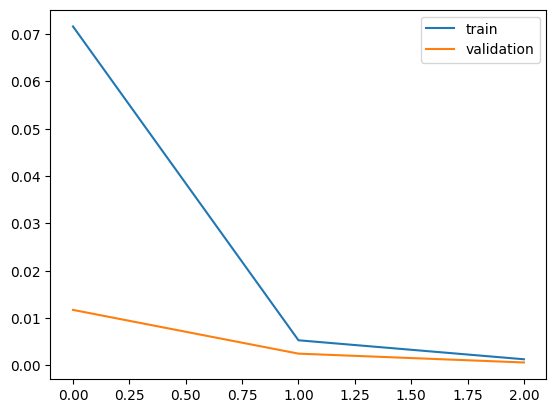

In [90]:
plt.plot(h_loss_train, label="train")
plt.plot(h_loss_val, label="validation")
plt.legend(loc="upper right")
plt.show()